In [2]:
from ReebGraph import SequentialReebGraph
import ReebGraph
from tests.simulator import brownian_motion
import numpy as np
import matplotlib.pyplot as plt
import importlib
import time
from tqdm import tqdm

In [3]:
TRAJECTORY_LENGTH = int(24 * 60 * 60 / 15)

N = 6

trajectories = np.array(
    [brownian_motion(TRAJECTORY_LENGTH, 2) for i in range(30 * N)]
    # [brownian_motion(15, 1) for i in range(4)]
)

# randomly mask points in each trajectory, replacing them with np.nan with probability p
p = 0
masks = np.random.rand(trajectories.shape[0], trajectories.shape[1]) < p
trajectories[masks] = np.nan

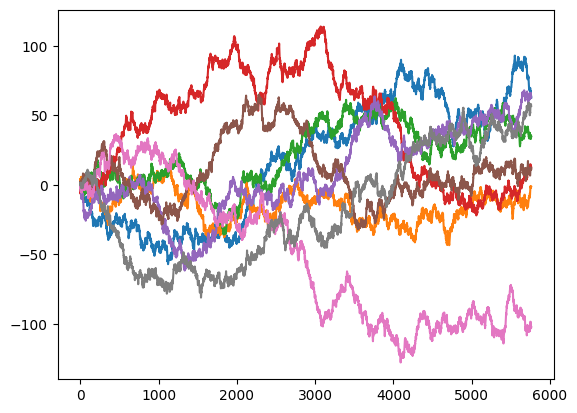

In [4]:
for _ in range(4):
    plt.plot(trajectories[_])

importlib.reload(ReebGraph)
reeb = ReebGraph.SequentialReebGraph(epsilon=1, store_trajectories=True, 
                                     trajectory_shape=trajectories[0].shape)

In [5]:
# partition the trajectories into groups of size N
trajectories_split = np.array([trajectories[i:i + 30] for i in range(0, len(trajectories), 30)])

In [7]:
runtime = 0
reeb_graphs = []
timings = []
for group in tqdm(trajectories_split):
    reeb = ReebGraph.SequentialReebGraph(epsilon=1)
    start = time.time()
    reeb.append_trajectories(group)
    timings.append(time.time() - start)
    reeb_graphs.append(reeb)

runtime += max(timings)
print(f"Individual Reeb Graphs could be computed in parallel in {max(timings)} seconds")

# do this repeatedly until there is only one graph
# form graphs into groups of two
# for each pair of graphs, merge the second one into the first using append_reeb
# then remove the second graph from the list
epsilon = 1
while len(reeb_graphs) > 1:
    epsilon *= 2
    new_reeb_graphs = []
    timings = []
    for i in range(0, len(reeb_graphs), 2):
        if i + 1 < len(reeb_graphs):
            start = time.time()
            reeb_graphs[i].append_reeb(reeb_graphs[i + 1], epsilon=epsilon)
            timings.append(time.time() - start)
        new_reeb_graphs.append(reeb_graphs[i])
    print(f"Reduced to {len(new_reeb_graphs)} Reeb Graphs in {max(timings)} seconds")
    runtime += max(timings)
    reeb_graphs = new_reeb_graphs

# Result: 16 agents processed in 45 seconds, so around 3 seconds per agent... too slow
print(f"Total runtime: {runtime} seconds for {N} agents")
print(f"{runtime/N} seconds per agent with effective epsilon {epsilon}")

100%|██████████| 6/6 [00:16<00:00,  2.71s/it]


Individual Reeb Graphs could be computed in parallel in 2.8240861892700195 seconds
Reduced to 3 Reeb Graphs in 1.8994498252868652 seconds
Reduced to 2 Reeb Graphs in 3.937350034713745 seconds
Reduced to 1 Reeb Graphs in 4.144984483718872 seconds
Total runtime: 12.805870532989502 seconds for 6 agents
2.1343117554982505 seconds per agent with effective epsilon 8


In [54]:
reeb_full = ReebGraph.SequentialReebGraph(epsilon=128)
start = time.time()
reeb_full.append_trajectories(trajectories)
runtime = time.time() - start
print(f"Full Reeb Graph computed in {runtime} seconds for {N} agents")
print(f"{runtime/N} seconds per agent with effective epsilon {reeb_full.epsilon}")

Full Reeb Graph computed in 273.36246061325073 seconds for 100 agents
2.733624606132507 seconds per agent with effective epsilon 128


In [18]:
importlib.reload(ReebGraph)
# # split the trajectories into N sets
# N = 2
# trajectories_split = np.array_split(trajectories, N)

# reeb_split = []
# for i in range(N):
#     reeb_split.append(ReebGraph.SequentialReebGraph(epsilon=2.5, store_trajectories=True))
#     reeb_split[i].append_trajectories(trajectories_split[i], compute_graph=False)

# reeb1 = reeb_split[0]
# reeb2 = reeb_split[1]

# # reeb_merge = reeb1.union(reeb2, adjust_epsilon=1)
# reeb_merge = reeb1.copy()

reeb_combined = ReebGraph.SequentialReebGraph(epsilon=2, store_trajectories=True)
reeb_combined.append_trajectories(trajectories)

for node in reeb_combined.nodes:
    print(node)

(0, np.float64(-1.769568861970014))
(0, np.float64(-0.8549642246280668))
(0, np.float64(-0.5872749147707155))


NameError: name 'reeb_combined' is not defined

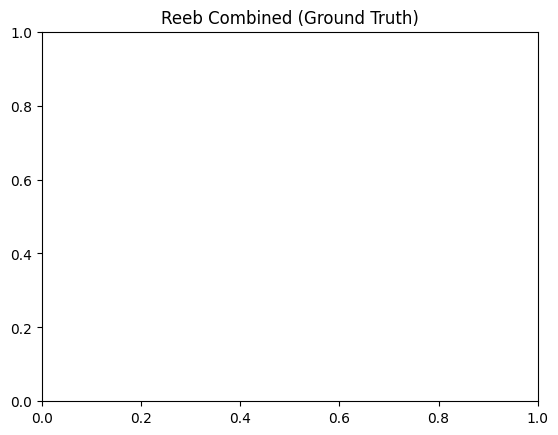

In [18]:
def plot_reeb(reeb):
    for edge in reeb.edges:
        dx = edge[1][0] - edge[0][0]
        dy = edge[1][1] - edge[0][1]
        plt.arrow(edge[0][0], edge[0][1], dx, dy, 
                head_width=0.5, head_length=0.6, fc='b', ec='b', 
                length_includes_head=True, alpha=0.6)

    for node in reeb.nodes:
        plt.scatter(node[0], node[1], c='r')
        
    for trajectory in reeb.trajectories:
        plt.plot(trajectory, alpha=0.2)

def plot_bundles(reeb):
    for trajectory in reeb.trajectories:
        plt.plot(trajectory, alpha=0.2)

    for t in range(len(reeb.bundles)):
        for bcenter in reeb.bundles[t].centers:
            plt.scatter(t, bcenter, c='r', alpha=0.2)

# plt.figure()
# plt.title("Reeb")
# # plot_reeb(reeb1)
# plot_bundles(reeb1)

# plt.figure()
# plt.title("Reeb 2")
# # plot_reeb(reeb2)
# plot_bundles(reeb2)

# plt.figure()
# plt.title("Both Reeb Graphs")
# plot_reeb(reeb1)
# plot_reeb(reeb2)


# plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1)
# plt.title("Reeb Union")
# plot_reeb(reeb_merge)

# plt.subplot(1, 2, 2)
plt.title("Reeb Combined (Ground Truth)")
plot_bundles(reeb_combined)

In [7]:
AGENT_COUNT = 1
trajectories = np.array(
    # two agents worth of trajectory data
    [brownian_motion(TRAJECTORY_LENGTH, 2) for i in range(AGENT_COUNT * 30)]
)
print(trajectories.shape)

(30, 5760, 2)


In [8]:
# naive method: append all trajectories
reeb_naive = SequentialReebGraph(epsilon=25)
reeb_naive.append_trajectories(trajectories)

print(f"Nodes: {len(reeb_naive.nodes)}, Edges: {len(reeb_naive.edges)}")

Nodes: 13738, Edges: 18078


In [4]:
# split the trajectories into N sets
N = 10
trajectories_split = np.array_split(trajectories, N)

reeb_split = []
for i in range(N):
    reeb_split.append(SequentialReebGraph(epsilon=25))
    reeb_split[i].append_trajectories(trajectories_split[i], compute_graph=False)


In [5]:
reeb_combined = reeb_split[0]

for i in range(1, N - 1):
    reeb_combined = reeb_combined.union(reeb_split[0], compute_graph=False)

reeb_combined = reeb_combined.union(reeb_split[0]) 
print(f"Nodes: {len(reeb_combined.nodes)}, Edges: {len(reeb_combined.edges)}")

Nodes: 235, Edges: 280


In [6]:
plot_reeb(reeb_combined)

NameError: name 'reeb_combined' is not defined

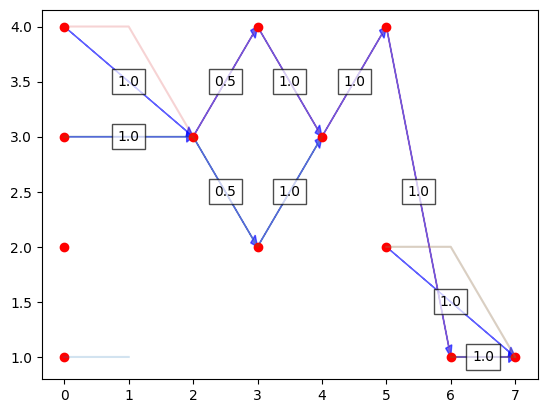

In [134]:
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt

def plot_reeb(reeb, show_weights=True):
    for start, end, weight in reeb.edges.data():
        dx = end[0] - start[0]
        dy = end[1] - start[1]
        plt.arrow(start[0], start[1], dx, dy, 
            head_width=0.1, head_length=0.1, fc='b', ec='b', 
            length_includes_head=True, alpha=0.6)
        # Add weight text near the middle of the arrow
        if show_weights:
            plt.text(start[0] + dx/2, start[1] + dy/2, 
                f'{weight["weight"]}', ha='center', va='center',
                bbox=dict(facecolor='white', alpha=0.7))

    for node in reeb.nodes:
        plt.scatter(node[0], node[1], c='r')
        
    for trajectory in reeb.trajectories:
        plt.plot(trajectory, alpha=0.2)

def plot_bundles(reeb):
    for trajectory in reeb.trajectories:
        plt.plot(trajectory, alpha=0.2)

    for t in range(len(reeb.bundles)):
        for bcenter in reeb.bundles[t].centers:
            plt.scatter(t, bcenter, c='r', alpha=0.2)


importlib.reload(ReebGraph)
SequentialReebGraph = ReebGraph.SequentialReebGraph

trajectories = np.array([
    [1, 1, np.nan, 2, np.nan, 2, 2, 1],
    [2, np.nan, np.nan, 4, np.nan, 2, 2,  1],
    [3, 3, 3, 2, 3, np.nan, 1, 1],
    [4, 4, 3, 4, 3, 4, 1, 1]
]).reshape(4, -1, 1)

reeb = SequentialReebGraph(epsilon=0.1, store_trajectories=True)
reeb.append_trajectories(trajectories)
plot_reeb(reeb)